# Natural Language Processing (NLP)-Based Patent Claim Analysis and Error Identification
*Kirk A. Sigmon, kirk.a.sigmon.th@dartmouth.edu*

This is **experimental** code used to evaluate the use of modern NLP techniques, such as SpaCy, to process patent claims.  This largely provides a more muscular version of the fantastic program [ClaimMaster](https://www.patentclaimmaster.com/), albeit theoretically in ways that benefit from modern NLP tools.

**THIS SHOULD NOT BE USED FOR REAL LEGAL WORK.**  This is experimental only, and is not intended for "live" use.  It is not legal advice, and should not be construed as such.  It is largely programmed in my free time, and is full of limitations and errors.  

## Preliminary Setup

Imports, dummy patent claim data, etc.

In [1]:
# !pip -q install spacy graphviz
#!python -m spacy download en_core_web_trf -q

## ----------------------------------------------------
## IMPORTS
## ----------------------------------------------------
import re, spacy
from dataclasses import dataclass
from typing import List, Optional, Dict, Tuple
import spacy
from IPython.display import HTML, display
from graphviz import Digraph

In [2]:
## ----------------------------------------------------
## DEMO CLAIMS FOR TESTING
## ----------------------------------------------------
demo_claims = {
    "patent_number": "000000000",
    "claims": [
        {
            "seq": 1,
            "text": (
                "An apparatus, comprising at least one processor and at least one memory including computer program code, "
                "the memory and the computer program code configured to, working with the processor, cause the apparatus "
                "to perform at least the following: receive a multiple touch input comprising a first touch input having "
                "a first text position within a first word such that the first text position is a text position between "
                "a first character of the first word and a last letter of the first word, and a second touch input having "
                "a second text position such that the second text position is a text position between a first character "
                "of a second word and a last letter of the second word; determine a first text selection point positioned "
                "outside of the first word based at least in part on the first text position being within the first word, "
                "such that the first text selection point is at least one of a text position preceding a first character "
                "of the first word, or a text position following a last letter of the first word; determine a second text "
                "selection point positioned outside of the second word based at least in part on the second text position, "
                "such that the second text selection point is at least one of a text position preceding a first character "
                "of the second word, or a text position following a last letter of the second word; and select text "
                "information between the first text selection point and the second text selection point."
            ),
        }
    ],
}

## Part 1: Antecedent Basis Analysis

Identifies Noun Phrases (NPs) and correlates them such that it can identify NPs that are used but not introduced (or, perhaps less worryingly, introduced but not used again).

In [3]:
## -----------------------------------------------------------------------------
## PART 1: PARSE CLAIM FOR ANTECEDENT BASIS ISSUES
## Finds basic stuff like un-introduced nouns, etc.
## -----------------------------------------------------------------------------


# PRELIMINARY DEFINITIONAL MATERIAL --------------------------------------------

INTRO_DETS = {"a", "an"}                                          # Intro determiners
INTRO_PHRASES = ["at least one", "one or more", "a plurality of"] # Plurlity defs
DEF_DETS = {"the", "said"}                                        # Definite determiners

# LOAD CONTENT -----------------------------------------------------------------
nlp = spacy.load("en_core_web_trf")                               # Load SpaCy

@dataclass
class Mention:
    kind: str          # "intro" or "ref"
    text: str
    key: str
    start: int         # character start
    end: int           # character end

# Helper function to normalize a Noun Phrase (NP) chunk to a key
def _span_key(span):

    # Define the head of the Noun Phrase
    head = span.root
    mods = []

    # For each token (word-like chunk) in the span...
    for tok in span:
        # If the chunk is a compound/modifier, append it
        if tok.dep_ in {"compound", "amod", "nummod"} and tok.head == head:
            mods.append(tok.lemma_.lower())

    # Return a SORTED list
    mods = sorted(set(mods))
    return " ".join(mods + [head.lemma_.lower()])

# Helper function to determine whether string start with an intro phrase (a, an)
def _starts_with_intro_phrase(span_text):

    # Standardize the span text by lowercasing and stripping it down
    t = span_text.lower().strip()

    # Now, search for the intro phrases and, if so, return as much
    for p in INTRO_PHRASES:
        if t.startswith(p + " "):
            return p
    return None

# Helper function to extract Noun Phrase (NP) mentions and classify them as
# either an introduction (e.g., "a ball") versus a reference (e.g., "the ball,"
# "said ball")
def extract_np_mentions(claim_text):

    # Run SpaCy on the claim text provided
    doc = nlp(claim_text)

    # Define an empty list of mentions of NPs
    mentions: List[Mention] = []

    # For each chunk available based on SpaCy processing...
    for chunk in doc.noun_chunks:

        # Define and lowercase the chunk
        chunk_text = chunk.text
        chunk_text_l = chunk_text.lower().strip()

        # Grab our FIRST and SECOND tokens
        first_tok = chunk[0].lower_
        second_tok = chunk[1].lower_ if len(chunk) > 1 else ""
        first_two = f"{first_tok} {second_tok}".strip()

        # Now, process through and figure out if we have an
        # introduction ("a," "an") and/or definite ("the," "said")
        is_intro = False
        is_ref = False
        if (first_tok in INTRO_DETS) or (_starts_with_intro_phrase(chunk_text)):
            is_intro = True
        if first_tok in DEF_DETS:
            is_ref = True

        # If somehow we figure out if it's a pronoun, jettison this process
        if chunk.root.pos_ == "PRON":
            continue

        # If we've successfully identified the NP as an intro ("a") or
        # definite ("the")
        if is_intro or is_ref:

            # Convert the chunk into a corresponding key
            key = _span_key(chunk)

            # Append to our mentions list an indicator of the key
            mentions.append(Mention(
                kind="intro" if is_intro else "ref",
                text=chunk_text,
                key=key,
                start=chunk.start_char,
                end=chunk.end_char
            ))

    # Return our list of mentions
    return mentions

# Helper function to basically pocess everything and collect errors
def analyze_intro_ref(claim_text):

    # Get our list of mentions
    mentions = extract_np_mentions(claim_text)

    # Define empty placeholders for our introductions for NPs and subsequent
    # uses of those NPs
    introduced: Dict[str, List[Mention]] = {}
    refs: List[Mention] = []

    # Begin to process through the mentions of a NP and tag them as either
    # the introduction or a follow-up reference
    for m in mentions:
        if m.kind == "intro":
            introduced.setdefault(m.key, []).append(m)
        else:
            refs.append(m)

    # Now, we need to find instances where the NP was used WITHOUT being
    # introduction.  We define an empty list, and append to that list where
    # we find NPs without introductions
    used_without_intro: List[Mention] = []
    referenced_keys = set()
    for r in refs:
        if r.key not in introduced:
            used_without_intro.append(r)
        else:
            referenced_keys.add(r.key)

    # Now, we also (somewhat) care about NPs mentioned but not later used.
    # Here, we make an empty list and walk through to find the instance
    # of the r
    introduced_never_referenced: List[Mention] = []
    for k, ms in introduced.items():
        if k not in referenced_keys:
            introduced_never_referenced.append(ms[0])

    # Return our list of mentions, introductions, references, and (perhaps most
    # importantly) the instances where we saw errors
    return {
        "mentions": mentions,
        "introduced": introduced,
        "refs": refs,
        "used_without_intro": used_without_intro,
        "introduced_never_referenced": introduced_never_referenced,
    }

# Helper function to extract instances where we have Noun Phrases (NPs) that
# are close together and comma-separated, suggesting enumeration (e.g.,
# something like "a ball, a net, a hoop")
def extract_enumerations(claim_text):

    # Char threshold for "close enough to probably be comma enumerated"
    comma_threshold = 150

    # Find all mentions in the claim text, and identify the introductons too
    mentions = extract_np_mentions(claim_text)
    intros = [m for m in mentions if m.kind == "intro"]

    # Empty variables for our enumerations
    enums: List[List[Mention]] = []
    current: List[Mention] = []

    # Roughly find enumerations
    for m in intros:
        if not current:
            current = [m]
            continue

        # Define some possible ranges
        prev = current[-1]
        between = claim_text[prev.end:m.start]
        gap = m.start - prev.end

        # If we see some sort of sufficiently small gap, we're probably
        # seeing an enumeration, so flag it as much
        if gap <= comma_threshold and ("," in between or " and " in between.lower() or " or " in between.lower() or ";" in between):
            current.append(m)
        else:
            if len(current) >= 2:
                enums.append(current)
            current = [m]
    if len(current) >= 2:
        enums.append(current)

    return enums

# Lazy HTML Highlighting for Beautification
def highlight_claim_ID_issues(claim_text: str) -> str:

    # Perform the relevant claim analysis
    analysis = analyze_intro_ref(claim_text)
    introduced = analysis["introduced"]
    referenced_keys = set(r.key for r in analysis["refs"] if r.key in introduced)
    used_wo_intro = {(m.start, m.end) for m in analysis["used_without_intro"]}
    intro_never = {(m.start, m.end) for m in analysis["introduced_never_referenced"]}

    # Define markup marks for HTML output
    marks: List[Tuple[int,int,str,str]] = []  # (start,end,color,label)

    for m in analysis["mentions"]:
        # OK Stuff
        if m.kind == "ref":
            if (m.start, m.end) in used_wo_intro:
                marks.append((m.start, m.end, "#ffcccc", "REF w/o INTRO"))
            else:
                marks.append((m.start, m.end, "#ccffcc", "REF ok"))
        # Problems
        else:
            # Introduced but not later referenced
            if (m.start, m.end) in intro_never:
                marks.append((m.start, m.end, "#fff0b3", "INTRO never ref"))
            else:
                # Introduced, might not be referenced later
                if m.key in referenced_keys:
                    marks.append((m.start, m.end, "#ccffcc", "INTRO used"))
                else:
                    marks.append((m.start, m.end, "#fff0b3", "INTRO never ref"))

    # Sort everything, keeping the longer span if there's any conflict
    marks.sort(key=lambda x: (x[0], -(x[1]-x[0])))
    filtered = []
    last_end = -1
    for s,e,c,lbl in marks:
        if s >= last_end:
            filtered.append((s,e,c,lbl))
            last_end = e

    # Output HTML for ease of viewing
    out = []
    i = 0
    for s,e,color,lbl in filtered:
        out.append(claim_text[i:s])
        frag = claim_text[s:e]
        out.append(f'<span title="{lbl}" style="background:{color}; padding:1px 2px; border-radius:3px;">{frag}</span>')
        i = e
    out.append(claim_text[i:])
    legend = """
    <div style="font-family:Arial; font-size:14px; line-height:1.4;">
      <div><b>LEGEND</b></div>
      <div><span style="background:#ccffcc; padding:1px 6px; border-radius:3px;">&nbsp;</span> OK</div>
      <div><span style="background:#fff0b3; padding:1px 6px; border-radius:3px;">&nbsp;</span> Introduced, not later used (may be OK)</div>
      <div><span style="background:#ffcccc; padding:1px 6px; border-radius:3px;">&nbsp;</span> Referenced without introduction (not OK)</div>
    </div>
    """
    body = "<div style='white-space:pre-wrap;'>" + "".join(out) + "</div>"
    return "<h2>Claim Introduction Issue Analysis</h2><br />" + legend + "<br /><br />" + body

In [4]:


claim = demo_claims["claims"][0]["text"]
HTML(highlight_claim_ID_issues(claim))

## Part 2: Claim Segmentation and Graphing

Splits claims into limitations, then processes those limitations to identify a verb, an object, and various clauses (*e.g.*, wherein clauses), conditions, ranges, "or" clauses, and the like.  

In [5]:
## -----------------------------------------------------------------------------
## PART 2: CLAIM SEGMENTATION + GRAPHING
## Produces a diagram that represents how different chunks of a claim are
## related to one another
## -----------------------------------------------------------------------------

# PRELIMINARY DEFINITIONAL MATERIAL --------------------------------------------

nlp = spacy.load("en_core_web_trf")                 # Load SpaCy for Parts of Speech (PoS) tagging
WS = re.compile(r"\s+")                            # Helps normalize whitespace

# Enumerations - detect "at least one of ..." list-intro pattern
ENUM_INTRO_RE = re.compile(r"\bat\s+least\s+one\s+of\b", re.IGNORECASE)

# Enumeration item starters - help avoid splitting a claim
# list into multiple "segments" by mistake
ENUM_ITEM_START_RE = re.compile(
    r"^\s*(a|an|the|at\s+least\s+one|one\s+or\s+more|a\s+plurality\s+of)\b",
    re.IGNORECASE,
)

# Starter phrases - helps flag segments that begin with some sort of definitional
# material as a node, even if not beginning with a verb per se
# This list is partially created by my own experience + GenAI recs, not
# comprehensive yet.
STARTER_RE = re.compile(
    "|".join(
        f"({p})"
        for p in [
            r"^and\b", r"^or\b",
            r"^comprising\b",
            r"^and\s+wherein\b", r"^and\s+whereby\b",
            r"^and\s+such\s+that\b",
            r"^where\b", r"^wherein\b", r"^whereby\b",
            r"^with\b", r"^without\b",
            r"^having\b", r"^including\b",
            r"^for\b", r"^for\s+use\s+in\b",
            r"^to\b", r"^so\s+that\b",
            r"^in\s+order\s+to\b",
            r"^configured\s+to\b",
            r"^operative\s+to\b",
            r"^adapted\s+to\b",
            r"^when\b", r"^whenever\b", r"^upon\b",
            r"^if\b",
            r"^responsive\s+to\b",
            r"^based\s+(at\s+least\s+in\s+part\s+on|in\s+part\s+on)\b",
            r"^while\b", r"^during\b",
            r"^before\b", r"^after\b",
            r"^prior\s+to\b", r"^subsequent\s+to\b",
            r"^except\s+that\b",
            r"^provided\s+that\b",
            r"^subject\s+to\b",
        ]
    ),
    re.IGNORECASE,
)

# Claim-verb whitelist - covers frequent claim verbs SpaCy sometimes mis-tags
# (e.g., "select," which it tends to not view as a verb although we treat it as
# much in certain computing-related claims)
COMMON_CLAIM_VERBS = {
    "select","receive","determine","transmit","send","generate","store","retrieve",
    "display","obtain","detect","identify","calculate","compute","compare","cause",
    "provide","perform","execute","create","update","access","output",
}

# Special enumeration patterns, generally reflective of a combinational list
# that doesn't necessarily use "or" in the case of "one OR the other," often
# instead used as like "at least one of X or Y or Z"
ENUM_INTROS = [
    "at least one of",
    "one or more of",
    "one or more selected from",
    "at least one selected from",
    "at least one chosen from",
    "one selected from",
    "any of",
    "either of",
]

# Two-ended range phrases to detect instances where we have ranges or other
# circumstances with two nodes
RANGE_SPECS = sorted([
    ("between",         " and ", "AND", "and"),
    ("from",            " to ",  "TO",  "to"),
    ("range between",   " and ", "AND", "and"),
    ("range from",      " to ",  "TO",  "to"),
    ("ranging between", " and ", "AND", "and"),
    ("ranging from",    " to ",  "TO",  "to"),
    ("in the range of", " to ",  "TO",  "to"),
    ("within",          " to ",  "TO",  "to"),
    ("spanning",        " to ",  "TO",  "to"),
], key=lambda x: -len(x[0]))


# HELPER FUNCTIONS -------------------------------------------------------------

# Whitespace normalization function
def norm_ws(s):
    return WS.sub(" ", (s or "").strip())

# Helper function to identify verb-ish words that SpaCy might nonetheless mis-tag,
# useful to catch actual verbs in certian contexts.
def _is_verbish(tok):
    if tok.pos_ in {"VERB", "AUX"}:
        return True
    if (tok.tag_ or "").startswith("VB"):
        return True
    return tok.lemma_.lower() in COMMON_CLAIM_VERBS

# HTML helper function to help cram stuff into a more vertical format, helps
# avoid some awkward blow-ups horizontally, especially for complex claims.
def _html_wrap(text, width=28, font_size=9, allow_html=False):

    # Handler where we might permit HTML tags in circumstances where we want to
    # bold text or something like that.
    if allow_html:
        safe = text or ""
    else:
        safe = (text or "").replace("&", "&amp;").replace("<", "&lt;").replace(">", "&gt;")

    # Basically a lot of code to create newlines from claim language that
    # doesn't otherwise have it, and largely for beautification
    words = norm_ws(safe).split(" ")
    lines, cur, cur_len = [], [], 0
    for w in words:
        add = len(w) + (1 if cur else 0)
        if cur and cur_len + add > width:
            lines.append(" ".join(cur))
            cur, cur_len = [w], len(w)
        else:
            cur.append(w)
            cur_len += add
    if cur:
        lines.append(" ".join(cur))

    # Emit Graphviz HTML labels with our line breaks
    body = "<BR/>".join(lines)

    # Return a table for GraphVis that also has the right definitional stuff.
    return f"""<
    <TABLE BORDER="0" CELLBORDER="0" CELLPADDING="2">
      <TR><TD ALIGN="LEFT"><FONT POINT-SIZE="{font_size}">{body}</FONT></TD></TR>
    </TABLE>
    >"""

# Helper function to build a robust regex
# for claim phrases like "one or more of," is flexible with whitespace
def _phrase_rx(phrase):
    return r"\b" + re.escape(phrase).replace(r"\ ", r"\s+") + r"\b"

# Helper function to identify enumeration intros and identify that they
# are often defining multiple leaves
def _enum_leaf_items(text):
    t = norm_ws(text or "")
    low = t.lower()

    # Find an instance of an enumeration introduction
    hit = None
    for intro in sorted(ENUM_INTROS, key=len, reverse=True):

        # Use the same phrase regex everywhere
        m = re.search(_phrase_rx(intro), low, flags=re.IGNORECASE)
        if m:
            hit = (intro, m.start())
            break
    if not hit:
        return None

    # Split the enumeration into a head and various leaves
    intro, pos = hit
    head = norm_ws(t[:pos + len(intro)]).strip(" ,")
    tail = norm_ws(t[pos + len(intro):]).strip(" ,")

    # If there is no tail, bail
    if not tail:
        return None

    # Normalize drafting patterns a bit
    tail = tail.replace(", and ", " and ").replace(", or ", " or ").replace(" and/or ", " or ")

    # Split tail into items, ignoring parentheses
    items = _top_level_split_parts(tail, " or ")

    # If there was no "or", try commas as a weaker fallback
    if len(items) <= 1:
        items = _top_level_split_parts(tail, ", ")

    # Handle lists with semicolons
    if len(items) <= 1:
        items = _top_level_split_parts(tail, "; ")

    # If still no split, try " and " as last resort (some lists use "and")
    if len(items) <= 1:
        items = _top_level_split_parts(tail, " and ")

    # Clean + keep non-empty
    items = [norm_ws(x).strip(" ,") for x in items if norm_ws(x).strip(" ,")]

    # Handle Oxford Comma tails
    items = [re.sub(r"^(and|or)\s+", "", x, flags=re.IGNORECASE).strip(" ,") for x in items]

    # Only explode if it looks like a real list
    if len(items) < 2:
        return None

    return head, items

# Function that splits a chunk/phrase ONLY at the top level - it can help avoid
# splitting stuff at the parentheticla level
def _top_level_split_parts(text, delim):

    # Define empty holders
    depth, parts, buf, i = 0, [], [], 0
    dlen = len(delim)
    dlow = delim.lower()
    t = text or ""

    # Iterate through the claim text character-by-character and identify (to
    # ultimately ignore) parenthetical sub-phrases.
    while i < len(t):
        ch = t[i]

        # Ignore parentheticals
        if ch == "(":
            depth += 1
            buf.append(ch); i += 1; continue
        if ch == ")" and depth > 0:
            depth -= 1
            buf.append(ch); i += 1; continue

        # Split if we're not in a parenthetical
        if depth == 0 and t[i:i+dlen].lower() == dlow:
            part = norm_ws("".join(buf)).strip(" ,")
            if part:
                parts.append(part)
            buf = []
            i += dlen
            continue

        buf.append(ch)
        i += 1

    # Flush trailing trext
    tail = norm_ws("".join(buf)).strip(" ,")
    if tail:
        parts.append(tail)

    return parts


# Function to split a claim chunk into a core requirement and alternatives, but
# also in a way that ignores enumerations/lists/"at least one of" type stuff.
def split_segment_into_core_and_or_alts(seg_text):

    # Split on top-level "or" (e.g., "A or B")
    parts = _top_level_split_parts(seg_text, " or ")
    if len(parts) <= 1:
        return norm_ws(seg_text), []

    # CAVEAT: If the "or" is an enumeration-intro ("at least one of ..."),
    # then do NOT treat it like a true alternative; the enumeration logic
    # will handle it as a structured list of items.
    first_or = (seg_text or "").lower().find(" or ")
    if first_or != -1:
        prefix = norm_ws((seg_text or "")[:first_or])
        if _enum_leaf_items(prefix):
            return norm_ws(seg_text), []

    # Here, we define the "core" as the stuff before the "or," then figure out
    # everything else as the alternative option(s)
    core = norm_ws(parts[0]).rstrip(" ,")
    alts = [norm_ws(p).strip(" ,") for p in parts[1:] if norm_ws(p).strip(" ,")]
    return core, alts


# Split a claim into segments using semicolons
# (as well as colons, at least for lists and the preamble)
def split_top_level_semicolons_claimaware(text):

    # Define empty holders
    segs = []
    depth = 0
    start = 0
    last_hard_boundary = 0

    # Helper to detect the list introduction stuff (e.g., "at least the following")
    LIST_INTRO_BEFORE_COLON_RE = re.compile(
        r"\bat\s+least\s+the\s+following\b(?:\s+\w+)?\s*$",
        re.IGNORECASE,
    )

    # Walk through the text...
    t = text or ""
    for i, ch in enumerate(t):

        # Track parentheses and avoid them so we don't break up junk in
        # parentheses, for now
        if ch == "(":
            depth += 1
            continue
        if ch == ")" and depth > 0:
            depth -= 1
            continue
        if depth != 0:
            continue

        # A period is a hard boundary, stop
        if ch == ".":
            last_hard_boundary = i
            continue

        # Split at a colon, this captures a variety of lists and claim preambles
        if ch == ":":
            before = t[start:i]
            if LIST_INTRO_BEFORE_COLON_RE.search(before):
                segs.append((start, i, t[start:i]))
                start = i + 1
                last_hard_boundary = start
            continue

        # In general, split on semicolons, but avoid the siutation where semicolons
        # are used in lists (properly or improperly)
        if ch == ";":
            before = t[last_hard_boundary:i]
            after = t[i+1:i+120]
            if ENUM_INTRO_RE.search(before) and ENUM_ITEM_START_RE.match(after):
                continue
            segs.append((start, i, t[start:i]))
            start = i + 1
            last_hard_boundary = start

    # Add the final tail as the last segment
    segs.append((start, len(t), t[start:]))
    return segs


# Helper function, turns spans into a dictionary of segments
def semicolon_first_segments(claim_text):
    segs = []

    # For each split-up portion of raw claim text...
    for s, e, t in split_top_level_semicolons_claimaware(claim_text):

        # Normalize the whitespace
        txt = norm_ws(t)

        # Jettison "and" when a drafter uses "; and ..." to chain limitations
        txt = re.sub(r"^\s*and\s+\b", "", txt, flags=re.IGNORECASE)
        if not txt:
            continue

        # Identify whether the chunk uses a known starter (e.g., "wherein")
        m = STARTER_RE.match(txt)

        # Cram it all into a defined segment with appropriate information
        segs.append({
            "idx": len(segs),
            "start": s,
            "end": e,
            "text": txt,
            "starter": (m.group(0).lower() if m else ""),
            "kind": "limitation",
        })

    # If the first limitation has "comprising/consisting,"
    # treat it like a preamble (just to avoid over-analyzing preambles)
    if segs:
        segs[0]["kind"] = "preamble"

    return segs


# Helper function to identify leaves inside of a limitation - that is,
# this is the function that chunks up a limitation into smaller nodes
def extract_marker_leaves(seg_text, covered_spans=None):

    # Use SpaCy to process the text, grab the segment text
    doc = nlp(seg_text)
    leaves = []
    txt = seg_text or ""

    # Handle covered spans
    covered_spans = list(covered_spans or [])

    # Find the next comma/semicolon boundary, ignoring parenthetical stuff
    def next_boundary(start_char):
        depth = 0
        for i in range(start_char, len(txt)):
            ch = txt[i]
            if ch == "(":
                depth += 1
            elif ch == ")" and depth > 0:
                depth -= 1
            elif depth == 0 and ch in {",", ";"}:
                return i
        return len(txt)

    # Detect enumeration-intro leaves like "at least one of A or B"
    for intro in sorted(ENUM_INTROS, key=len, reverse=True):
        rx = _phrase_rx(intro)
        for m in re.finditer(rx, txt, flags=re.IGNORECASE):

            # Grab from the intro through the next boundary
            ms = m.start()
            end = next_boundary(m.end())
            frag = norm_ws(txt[ms:end])

            # Only keep if it has at least one obvious separator
            if (" or " in frag.lower()) or (", " in frag) or (" and " in frag.lower()) or (";" in frag):
                leaves.append({"label": "enum", "span": (ms, end), "text": frag})

    # Special case handling a "based on" type limitation
    for tok in doc:
        if tok.lemma_.lower() == "base" and tok.text.lower() == "based":
            prep_on = next((c for c in tok.children if c.dep_ == "prep" and c.lemma_.lower() == "on"), None)
            if not prep_on:
                continue
            end_i = max(t.i for t in prep_on.subtree) + 1
            span = doc[tok.i:end_i]
            leaves.append({"label": "based on", "span": (span.start_char, span.end_char), "text": span.text})

    # Special case handling a "in response to" type limitation
    for tok in doc:
        if tok.lemma_.lower() != "response" or tok.pos_ not in {"NOUN", "PROPN"}:
            continue
        prep_to = next((c for c in tok.children if c.dep_ == "prep" and c.lemma_.lower() == "to"), None)
        if not prep_to:
            continue
        start_i = tok.i - 1 if tok.i - 1 >= 0 and doc[tok.i - 1].lemma_.lower() == "in" else tok.i
        end_i = max(t.i for t in prep_to.subtree) + 1
        span = doc[start_i:end_i]
        leaves.append({"label": "in response to", "span": (span.start_char, span.end_char), "text": span.text})

    # Special case handling for ranges
    for kw, delim, _node_lbl, _edge_lbl in RANGE_SPECS:
        kw_rx = _phrase_rx(kw)
        for m in re.finditer(kw_rx, txt, flags=re.IGNORECASE):

            # Grab from the keyword through the next boundary
            ms = m.start()
            end = next_boundary(m.end())
            frag = norm_ws(txt[ms:end])

            # Only keep if the delimiter actually appears
            low = frag.lower()
            ok = False
            if delim.strip().lower() in low:
                ok = True
            elif delim.strip().lower() == "and" and (", and " in low or " and/or " in low or " and or " in low):
                ok = True
            elif delim.strip().lower() == "to" and (" through " in low or " until " in low):
                ok = True

            # Prevent adding leaves covered by other leaves
            if ok:
                contained = any(
                    (leaf["span"][0] <= ms and end <= leaf["span"][1])
                    for leaf in leaves
                )
                if contained:
                    continue

                leaves.append({"label": kw, "span": (ms, end), "text": frag})

    # Pull special markers ("such that", "wherein", "whereby") as leaves
    for label in ("such that", "wherein", "whereby"):
        rx = re.compile(rf"\b{re.escape(label)}\b", re.IGNORECASE)
        for m in rx.finditer(txt):
            ms, me = m.start(), m.end()
            tail = txt[me:]
            end = len(txt) if (label == "such that" and ENUM_INTRO_RE.search(tail)) else next_boundary(me)
            span = (ms, end)
            leaves.append({"label": label, "span": span, "text": norm_ws(txt[span[0]:span[1]])})

    # Prune leaves that appear twice, often catches instances where a range tries
    # to tie back to the original verb rather than a clause of a limitation
    range_labels = {kw for (kw, _delim, _node_lbl, _edge_lbl) in RANGE_SPECS}
    filtered = []
    for leaf in leaves:
        s0, e0 = leaf["span"]

        # Only range leaves are candidates for removal here
        if leaf["label"] in range_labels:
            contained = any(
                (other is not leaf) and (other["span"][0] <= s0) and (e0 <= other["span"][1])
                for other in leaves
            )
            if contained:
                continue

        filtered.append(leaf)

    leaves = filtered

    # Remove overlapping leaves, performed only for same kind of leaf
    leaves.sort(key=lambda x: (x["span"][0], -(x["span"][1] - x["span"][0])))

    out = []
    for leaf in leaves:
        s0, e0 = leaf["span"]

        # If a same-label leaf already occupies this territory, keep only the longest.
        # This preserves useful overlapping structures across different labels.
        replaced = False
        for i, prev in enumerate(out):
            s1, e1 = prev["span"]
            overlaps = (s0 < e1) and (s1 < e0)
            if overlaps and prev["label"] == leaf["label"]:
                if (e0 - s0) > (e1 - s1):
                    out[i] = leaf
                replaced = True
                break

        if not replaced:
            out.append(leaf)

    # Add spans for words not accounted for by other leaves for comprehensiveness
    def _add_remainder_leaves(out_leaves):
        n = len(txt)
        if n == 0:
            return out_leaves

        spans = []

        # Account for all existing leaf spans
        for leaf in out_leaves:
            s, e = leaf.get("span", (None, None))
            if s is None or e is None:
                continue
            s = max(0, min(n, s))
            e = max(0, min(n, e))
            if e > s:
                spans.append((s, e))

        # Account for already-rendered verb/object/etc spans so remainder does not include them
        for s, e in covered_spans:
            s = max(0, min(n, s))
            e = max(0, min(n, e))
            if e > s:
                spans.append((s, e))

        # If nothing was extracted AND nothing was covered, the entire limitation becomes a single leaf
        # (this should be rare, but keeps behavior sensible).
        if not spans:
            frag = norm_ws(txt).strip()
            return [{"label": "remainder", "span": (0, n), "text": frag}] if frag else []

        # Merge overlaps/adjacent spans
        spans.sort()
        merged = []
        cs, ce = spans[0]
        for s, e in spans[1:]:
            if s <= ce:
                ce = max(ce, e)
            else:
                merged.append((cs, ce))
                cs, ce = s, e
        merged.append((cs, ce))

        # Find gaps
        gaps = []
        cur = 0
        for s, e in merged:
            if cur < s:
                gaps.append((cur, s))
            cur = max(cur, e)
        if cur < n:
            gaps.append((cur, n))

        # Add each meaningful gap as a leaf
        out2 = list(out_leaves)
        for s, e in gaps:
            frag_raw = txt[s:e]
            frag = norm_ws(frag_raw).strip(" ,;:")
            if not frag:
                continue

            # Avoid tiny punctuation fragments that make the diagram noisy
            if len(frag) < 6:
                continue

            # Tighten span to non-whitespace edges
            left, right = s, e
            while left < right and txt[left].isspace():
                left += 1
            while right > left and txt[right - 1].isspace():
                right -= 1

            out2.append({"label": "remainder", "span": (left, right), "text": norm_ws(txt[left:right])})

        return out2

    out = _add_remainder_leaves(out)

    # Keep output in a stable order after overlap cleanup
    out.sort(key=lambda x: (x["span"][0], x["span"][1]))
    return out


# This defines a "Frame" that involves a verb, some object, and various
# subsidiary leaves/alternatives.
def build_action_frame(seg_text):
    core_text, or_alts = split_segment_into_core_and_or_alts(seg_text)

    # Strip leading "and/or," just in case
    core_for_anchor = re.sub(r"^\s*(and|or)\s+\b", "", core_text, flags=re.IGNORECASE)
    doc_core = nlp(core_for_anchor)

    # Identify covered spans
    doc_full = nlp(seg_text)

    # Identify our anchor verb (and, if needed, fall back to "verb-ish" stuff)
    anchor = doc_core[:].root
    if not _is_verbish(anchor):
        anchor = next((t for t in doc_core if _is_verbish(t)), anchor)
    anchor_verb = anchor.lemma_ if _is_verbish(anchor) else "(no-verb)"

    # Find the corresponding anchor token in the FULL doc so we can mark its span as covered
    anchor_full = doc_full[:].root
    if not _is_verbish(anchor_full):
        anchor_full = next((t for t in doc_full if _is_verbish(t)), anchor_full)

    covered_spans = []
    if _is_verbish(anchor_full):
        covered_spans.append((anchor_full.idx, anchor_full.idx + len(anchor_full.text)))

    # As best we can given SpaCy output, try to identify the proper object of the verb.
    obj_np = None
    obj_span_full = None

    if _is_verbish(anchor):
        dobj = next((c for c in anchor.children if c.dep_ in {"dobj", "obj", "attr"}), None)
        if dobj is not None:
            np = next((ch for ch in doc_core.noun_chunks if ch.start <= dobj.i < ch.end), None)
            obj_np = np.text if np is not None else dobj.text
        else:
            after = [ch for ch in doc_core.noun_chunks if ch.start > anchor.i]
            if after:
                obj_np = after[0].text

    # Figure out object's full character span
    if _is_verbish(anchor_full):
        dobj_full = next((c for c in anchor_full.children if c.dep_ in {"dobj", "obj", "attr"}), None)
        if dobj_full is not None:

            # Prefer the noun chunk that contains the object token, if present
            np_full = next((ch for ch in doc_full.noun_chunks if ch.start <= dobj_full.i < ch.end), None)
            if np_full is not None:
                obj_span_full = (np_full.start_char, np_full.end_char)
            else:
                obj_span_full = (dobj_full.idx, dobj_full.idx + len(dobj_full.text))
        else:

            # Fallback: first noun chunk after the verb in the full doc
            after_full = [ch for ch in doc_full.noun_chunks if ch.start > anchor_full.i]
            if after_full:
                obj_span_full = (after_full[0].start_char, after_full[0].end_char)

    if obj_span_full:
        covered_spans.append(obj_span_full)

    # Extract marker leaves from the full limitation text, but ensure "remainder"
    # excludes verb/object spans (and any other covered spans we pass in).
    leaves = extract_marker_leaves(seg_text, covered_spans=covered_spans)

    # Return what we found, including leaves, alternatives, etc.
    return {
        "anchor_verb": anchor_verb,
        "object_np": obj_np,
        "leaves": leaves,
        "or_alternatives": or_alts,
        "core_text": core_text,
    }


# Helper function to remove leaf spans from a limitation to show the
# "main requirement" text, should we want to see it
def remove_leaf_spans(seg_text, leaves):

    # Sort our spans
    spans = sorted((leaf["span"] for leaf in leaves), key=lambda x: x[0])

    # Stitch together all the non-leaf text in order
    out = []
    i = 0
    for s, e in spans:
        out.append(seg_text[i:s])
        i = e
    out.append(seg_text[i:])

    # Normalize punctuation spacing after deletions
    return norm_ws("".join(out).replace(" ,", ",").replace(" ;", ";"))


# GRAPH OUTPUT -----------------------------------------------------------------

# Helper function to render everything in a somewhat-okay version of GraphViz,
# prioritizing things in a vertical format
def render_action_leaf_graphviz(segs):
    graphs = []

    # Create one standalone diagram per limitation
    for s in segs:

        # Define our graph
        g = Digraph(
            f"claim_req_{s['idx']}",
            graph_attr={
                "rankdir": "TB",     # Top to bottom
                "fontsize": "10",    # Font size
                "nodesep": "0.12",   # Horizontal separation between nodes
                "ranksep": "0.80",   # Vertical separation between levels
            },
        )

        # Define node/edge defaults
        g.attr("node", shape="box", style="rounded", fixedsize="false")
        g.attr("edge", fontsize="9")

        # Build the appropriate action frame (verb, object, etc.)
        frame = build_action_frame(s["text"])

        # Force some IDs to avoid odd issues in GraphViz
        seg_id = f"seg_{s['idx']}"
        act_id = f"seg_{s['idx']}_act"

        # Draw the limitation box, bolded limitation text (full text)
        g.node(
            seg_id,
            label=_html_wrap(
                f"<B>Limitation {s['idx']}:</B><br /><br />{s['text']}",
                width=75,
                font_size=12,
                allow_html=True,
            ),
            shape="box",
            style="rounded",
        )
        g.node(act_id, label=_html_wrap(f"action: {frame['anchor_verb']}", width=20, font_size=10), shape="ellipse")
        g.edge(seg_id, act_id, label="action")

        # Draw the object node
        if frame["object_np"]:
            obj_id = f"seg_{s['idx']}_obj"
            g.node(obj_id, label=_html_wrap(f"object: {frame['object_np']}", width=35, font_size=9))
            g.edge(act_id, obj_id, label="object")

        # Track whether an OR structure is already represented inside a leaf
        handled_or_inside_leaf = False

        # Render each extracted leaf as a child node
        for k, leaf in enumerate(frame["leaves"]):
            leaf_text = leaf["text"] or ""

            # If a leaf is an enumeration intro ("at least one of ...", "one or more of ..."),
            # explode it into child item nodes so it always becomes a visible structure
            enum = _enum_leaf_items(leaf_text)
            if enum:
                head, items = enum
                handled_or_inside_leaf = True

                # Draw the enum head (the intro phrase) as a leaf node
                head_id = f"seg_{s['idx']}_leaf_{k}_enum_head"
                g.node(head_id, label=_html_wrap(head, width=45, font_size=9), shape="note", style="solid")
                g.edge(act_id, head_id, label="leaf")

                # Draw a connector node to show "this is a list of items"
                conn_id = f"seg_{s['idx']}_leaf_{k}_enum_conn"
                g.node(conn_id, label="ENUM", shape="ellipse", style="dashed")
                g.edge(head_id, conn_id, label="items")

                # Draw each item as its own node
                for j, it in enumerate(items):
                    it_id = f"seg_{s['idx']}_leaf_{k}_enum_{j}"
                    g.node(it_id, label=_html_wrap(it, width=45, font_size=9), shape="note", style="solid")
                    g.edge(conn_id, it_id, label="item")

                # Skip default rendering for this leaf
                continue

            # If a leaf contains a range phrase, explode range under this
            # leaf (don't attach to some other leaf)
            handled_range_inside_leaf = False
            for kw, delim, node_lbl, edge_lbl in RANGE_SPECS:

                m = re.search(_phrase_rx(kw), leaf_text, flags=re.IGNORECASE)
                if not m:
                    continue

                # Split the leaf into a "head" (everything up to the range keyword)
                # and a "tail" (the remainder, which should include both bounds).
                head = norm_ws(leaf_text[:m.end()].strip(" ,"))
                tail = norm_ws(leaf_text[m.end():].strip(" ,"))

                # Normalize common drafting punctuation so splitting works reliably
                tail = tail.replace(", and ", " and ").replace(", or ", " or ").replace(" and/or ", " and ")

                # Try to split the tail into two bounds using the configured delimiter
                bounds = [b for b in _top_level_split_parts(tail, delim) if b]

                # Backoff delimiters for common drafter variants
                if len(bounds) < 2 and delim.strip().lower() == "and":
                    for alt_delim in [" and ", ", and ", " and/or ", " or "]:
                        bounds = [b for b in _top_level_split_parts(tail, alt_delim) if b]
                        if len(bounds) >= 2:
                            break
                if len(bounds) < 2 and delim.strip().lower() == "to":
                    for alt_delim in [" to ", " through ", " until "]:
                        bounds = [b for b in _top_level_split_parts(tail, alt_delim) if b]
                        if len(bounds) >= 2:
                            break

                if head and len(bounds) >= 2:
                    handled_range_inside_leaf = True

                    # Create a leaf node for the head (e.g., "such that ... between")
                    head_id = f"seg_{s['idx']}_leaf_{k}_rng_inleaf_head"
                    g.node(head_id, label=_html_wrap(head, width=45, font_size=9), shape="note", style="solid")
                    g.edge(act_id, head_id, label="leaf")

                    # Create the connector node (AND/TO)
                    conn_id = f"seg_{s['idx']}_leaf_{k}_rng_inleaf_conn"
                    g.node(conn_id, label=node_lbl, shape="ellipse", style="dashed")
                    g.edge(head_id, conn_id, label="bounds")

                    # Add the two bounds under the connector
                    for j, b in enumerate(bounds[:2]):
                        b_id = f"seg_{s['idx']}_leaf_{k}_rng_inleaf_{j}"
                        g.node(b_id, label=_html_wrap(b, width=45, font_size=9), shape="note", style="solid")
                        g.edge(conn_id, b_id, label=edge_lbl)

                    break

            # If we exploded a range inside this leaf, skip the rest of leaf
            if handled_range_inside_leaf:
                continue

            # Range handling - if we see a range, handle it like the "or" stuff
            handled_range = False
            for kw, delim, node_lbl, edge_lbl in RANGE_SPECS:

                # Find keyword matches with a robust phrase regex
                m = re.search(_phrase_rx(kw), leaf_text, flags=re.IGNORECASE)
                if not m:
                    continue

                # Treat the keyword as the range head, split the rest
                head = norm_ws(leaf_text[:m.end()].strip(" ,"))
                tail = norm_ws(leaf_text[m.end():].strip(" ,"))

                # Normalize common punctuation and "and/or" for ease of split
                tail = tail.replace(", and ", " and ").replace(", or ", " or ").replace(" and/or ", " and ")

                # Try the primary delimiter first
                bounds = [b for b in _top_level_split_parts(tail, delim) if b]

                # Back off delimiters for common variants
                if len(bounds) < 2 and delim.strip().lower() == "and":
                    for alt_delim in [" and ", ", and ", " and/or ", " or "]:
                        bounds = [b for b in _top_level_split_parts(tail, alt_delim) if b]
                        if len(bounds) >= 2:
                            break
                if len(bounds) < 2 and delim.strip().lower() == "to":
                    for alt_delim in [" to ", " through ", " until "]:
                        bounds = [b for b in _top_level_split_parts(tail, alt_delim) if b]
                        if len(bounds) >= 2:
                            break

                # Make sure we can find two bounds, or else the claim is broke
                if head and len(bounds) >= 2:
                    handled_range = True

                    # Range head
                    head_id = f"seg_{s['idx']}_leaf_{k}_rng_head"
                    g.node(head_id, label=_html_wrap(head, width=45, font_size=9), shape="note", style="solid")
                    g.edge(act_id, head_id, label="leaf")

                    # Connector node (AND/TO)
                    conn_id = f"seg_{s['idx']}_leaf_{k}_rng_conn"
                    g.node(conn_id, label=node_lbl, shape="ellipse", style="dashed")
                    g.edge(head_id, conn_id, label="bounds")

                    # Add bounds as child nodes
                    for j, b in enumerate(bounds[:2]):
                        b_id = f"seg_{s['idx']}_leaf_{k}_rng_{j}"
                        g.node(b_id, label=_html_wrap(b, width=45, font_size=9), shape="note", style="solid")
                        g.edge(conn_id, b_id, label=edge_lbl)

                if handled_range:
                    break

            if handled_range:
                continue

            # Default leaf rendering (all other leafs, just in case)
            leaf_id = f"seg_{s['idx']}_leaf_{k}"

            # Remainder leaves get rendered differently so that we can rapidly
            # diagnose outside cases (or system issues)
            if leaf.get("label") == "remainder":
                g.node(leaf_id, label=_html_wrap(leaf_text, width=45, font_size=9), shape="note", style="dashed")
            else:
                g.node(leaf_id, label=_html_wrap(leaf_text, width=45, font_size=9), shape="note")

            g.edge(act_id, leaf_id, label="leaf")

        # If the limitation itself has an "OR," do a segment-level split
        if (not handled_or_inside_leaf) and frame["or_alternatives"]:
            seg_or_id = f"seg_{s['idx']}_or"
            g.node(seg_or_id, label="OR", shape="ellipse", style="dashed")
            g.edge(act_id, seg_or_id, label="alt")

            # Initial/left branch is the core text
            left_txt = norm_ws(frame["core_text"] or s["text"]).strip(" ,")
            left_id = f"seg_{s['idx']}_or_0"
            g.node(left_id, label=_html_wrap(left_txt, width=45, font_size=9), shape="note", style="solid")
            g.edge(seg_or_id, left_id, label="or")

            # Remaining branches are the alternatives
            for j, alt in enumerate(frame["or_alternatives"], start=1):
                alt_id = f"seg_{s['idx']}_or_{j}"
                g.node(alt_id, label=_html_wrap(alt, width=45, font_size=9), shape="note", style="solid")
                g.edge(seg_or_id, alt_id, label="or")

        # Add to the graph
        graphs.append(g)

    return graphs


# SINGULAR FUNCTION TO CALL ----------------------------------------------------

def diagram_claim_with_marker_leaves(claim_text):

    # Split the claim into separate limitations
    segs = semicolon_first_segments(claim_text)

    # Display each limitation graph separately
    for g in render_action_leaf_graphviz(segs):
        display(g)

    # Return the underlying segments too
    return {"segments": segs}


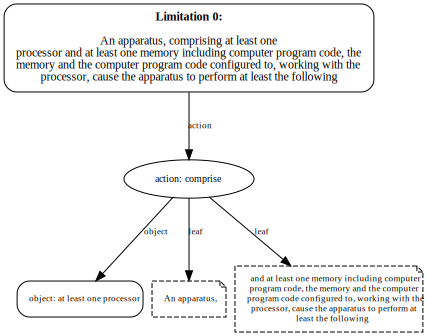

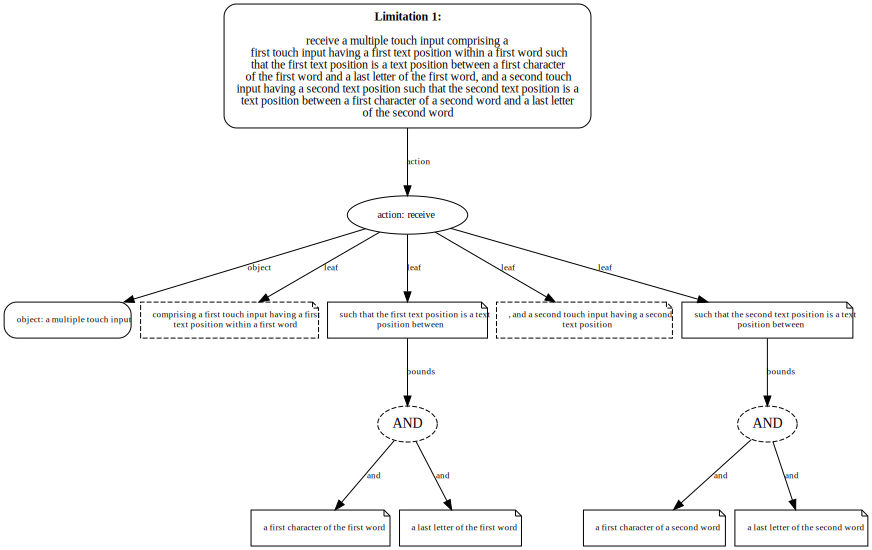

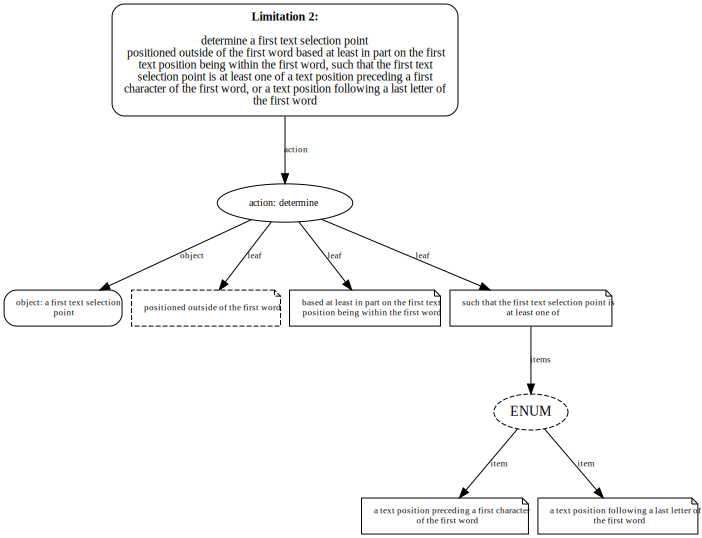

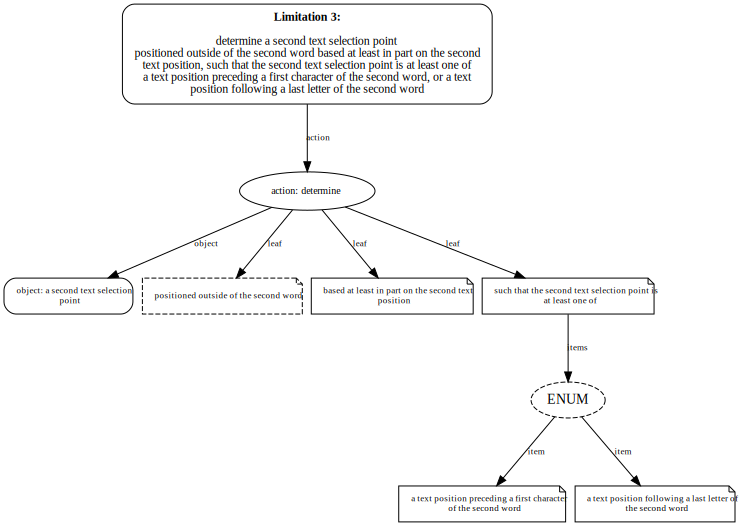

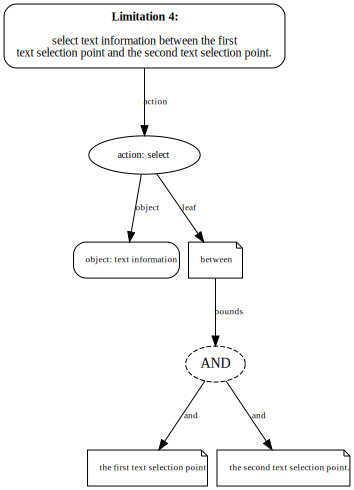

In [6]:
claim = demo_claims["claims"][0]["text"]  # if you have it defined
result = diagram_claim_with_marker_leaves(claim)